# Modeling a Moving Average Process

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Forecast the volume of widget sales from the XYZ Widget Company

In [4]:
url1 = ('https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/refs/heads/master/data/widget_sales.csv')

df = pd.read_csv(url1)

df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


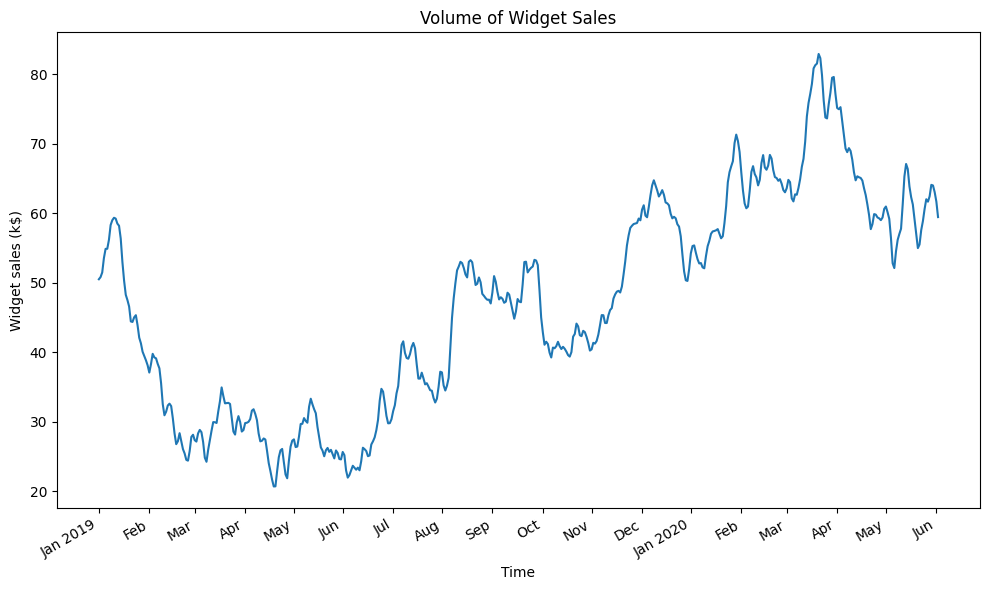

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')
plt.title('Volume of Widget Sales')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()  # # Automatically format x-axis date labels to avoid overlap
plt.tight_layout()

#plt.savefig('CH04_F01_peixeiro.png', dpi=300)

#### Augmented Dickey Fuller's test

    p-value > alpha ; H0: Not stationary
    p-value < alpha ; Ha: Stationary

In [7]:
# Augmented Dickey Fuller's test
ADF_result = adfuller(df['widget_sales'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')
print()

if ADF_result[1] > 0.05:        # p-value > alpha
    print('H0: Not Stationary')
else:                           # p-value < alpha
    print('Ha: Stationary')

ADF Statistic: -1.5121662069359039
p-value: 0.527484535227261

H0: Not Stationary


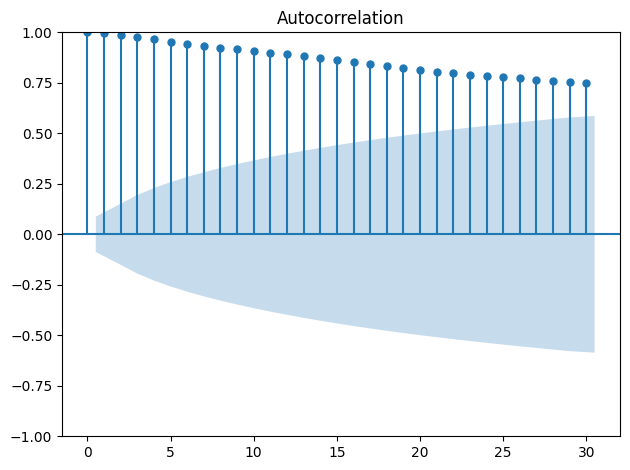

In [8]:
# Plot Auto Correlation Function
plot_acf(df['widget_sales'], lags=30);

plt.tight_layout()

Not Stationary. We must apply transformations to make it stationary. We will try to stabilize the trend by applying
a first-order differencing. For a first-order differencing, n will be equal to 1.

In [10]:
# First-order differencing
widget_sales_diff = np.diff(df['widget_sales'], n=1)

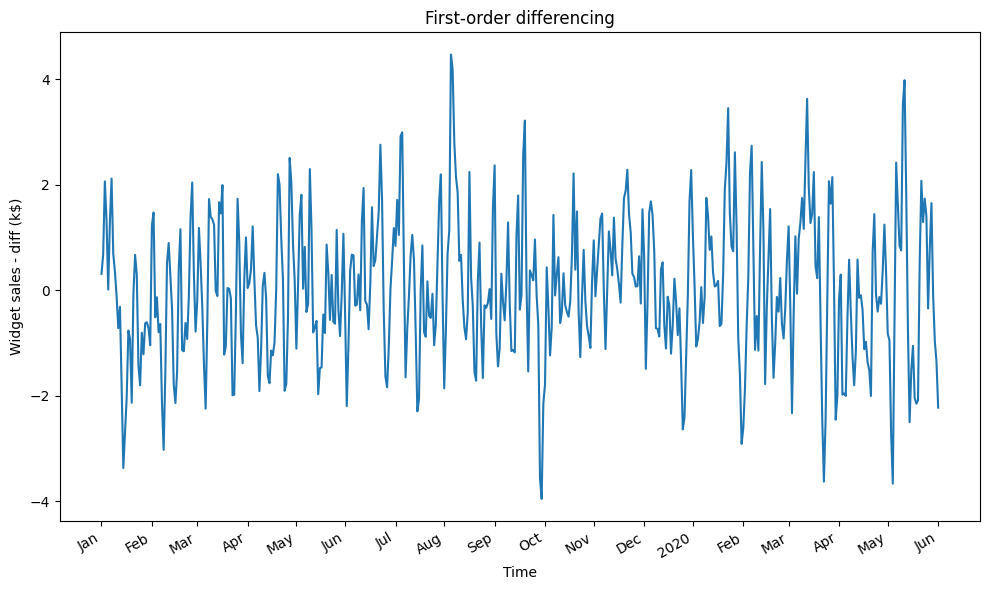

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(widget_sales_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')
plt.title('First-order differencing')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [12]:
# Augmented Dickey Fuller's test
ADF_result = adfuller(widget_sales_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')
print()

if ADF_result[1] > 0.05:        # p-value > alpha
    print('H0: Not Stationary')
else:                           # p-value < alpha
    print('Ha: Stationary')

ADF Statistic: -10.576657780341963
p-value: 7.07692281858714e-19

Ha: Stationary


Let's confirm it visualy:

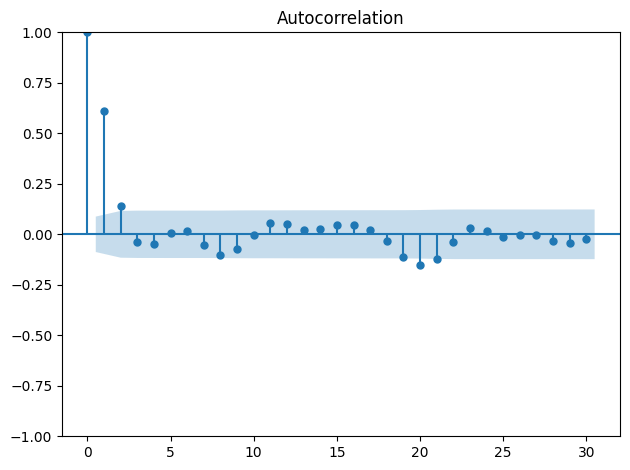

In [14]:
# Plot Auto Correlation Function
plot_acf(widget_sales_diff, lags=30);

plt.tight_layout()

## Forecasting a Moving Average Process

In [16]:
df_diff = pd.DataFrame({'widget_sales_diff': widget_sales_diff})

comp = len(df_diff)

train = df_diff[:int(0.9*comp)]  # First 90% of the data 
test = df_diff[int(0.9*comp):]   # Last 10% of the data

print(len(train))
print(len(test))

449
50


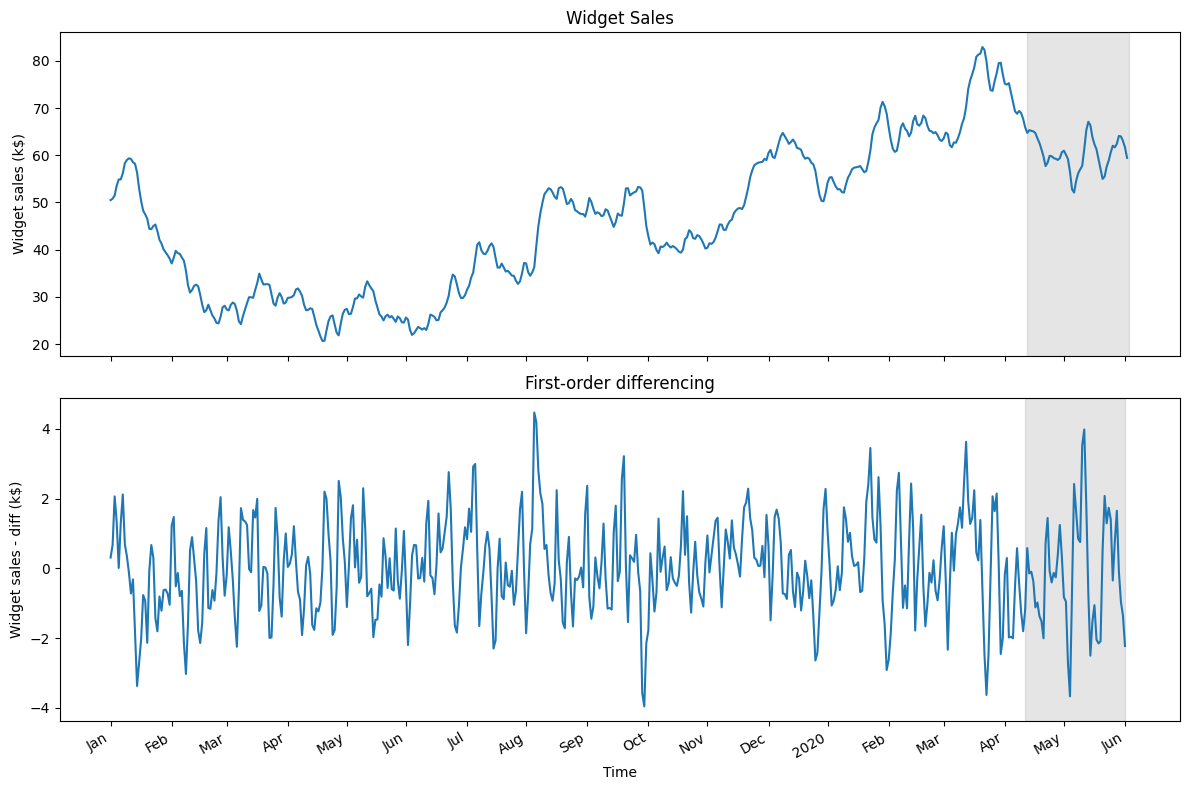

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))

ax1.plot(df['widget_sales'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget sales (k$)')
ax1.set_title('Widget Sales')
ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(df_diff['widget_sales_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget sales - diff (k$)')
ax2.set_title('First-order differencing')
ax2.axvspan(449, 498, color='#808080', alpha=0.2)

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':                # If method is 'mean', calculate the rolling mean forecast
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':               # If method is 'last', calculate the forecast based on the last observed value
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':                 # If method is 'MA', calculate the forecast using a moving average model (SARIMAX)
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [19]:
pred_df = test.copy()

TRAIN_LEN = len(train)  # Define the length of the training data
HORIZON = len(test)     # Define the length of the test data (forecast horizon)
WINDOW = 2              # Define the window size for rolling forecast

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()

,widget_sales_diff,pred_mean,pred_last_value,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994


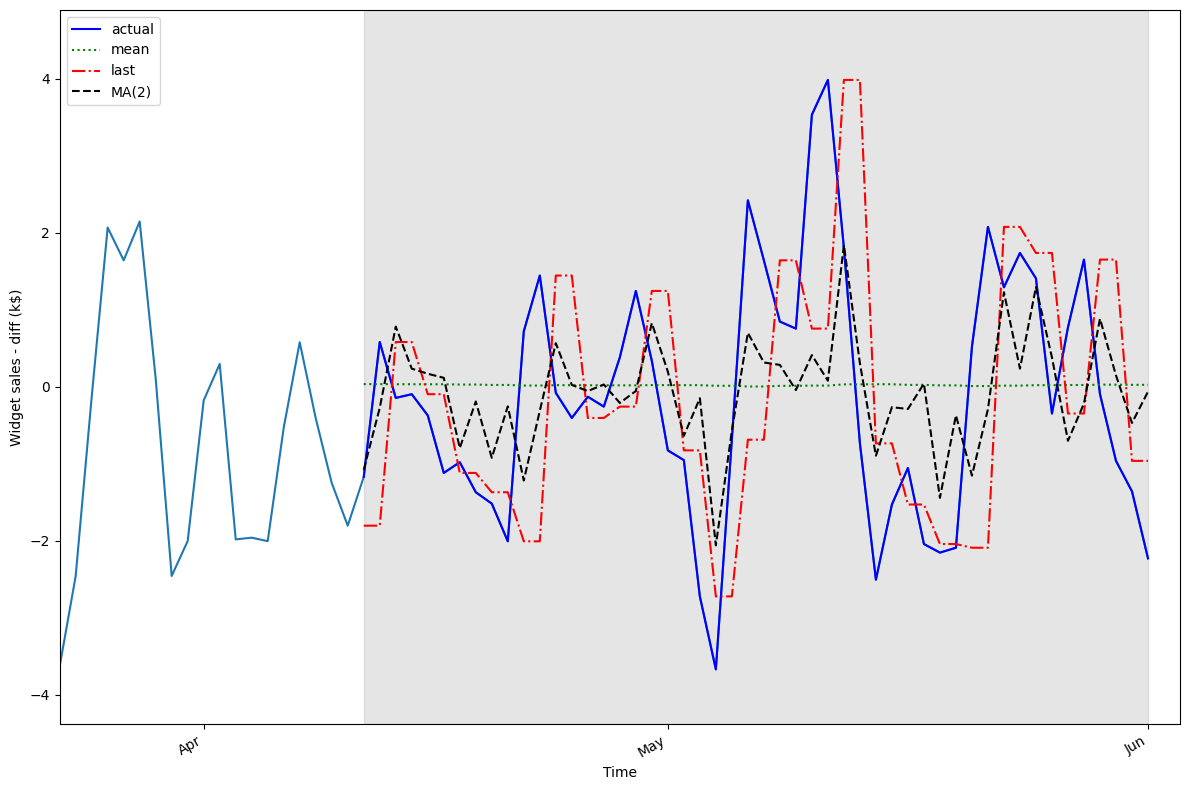

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))                      # Create a new figure and axis with a size of 12x8 inches

ax.plot(df_diff['widget_sales_diff'])                        # Plot the 'widget_sales_diff' column from 'df_diff' DataFrame as a line
ax.plot(pred_df['widget_sales_diff'], 'b-', label='actual')  # Plot the actual data in blue with solid line and label it as 'actual'
ax.plot(pred_df['pred_mean'], 'g:', label='mean')            # Plot the predicted mean with green dash-dot line and label it as 'mean'
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')     # Plot the predicted last value with red dash-dot line and label it as 'last'
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')            # Plot the predicted MA(2) with black dashed line and label it as 'MA(2)'

ax.legend(loc=2)                           # Display the legend in the top-left corner of the plot

ax.set_xlabel('Time')                      # Set the label for the x-axis as 'Time'
ax.set_ylabel('Widget sales - diff (k$)')  # Set the label for the y-axis as 'Widget sales - diff (k$)'

ax.axvspan(449, 498, color='#808080', alpha=0.2)             # Highlight the region from x=449 to x=498 with a gray shaded area

ax.set_xlim(430, 500)                      # Set the limits of the x-axis to range from 430 to 500

plt.xticks(                                # Set custom tick locations and labels for the x-axis
    [439, 468, 498],                       # Specify the x locations of the ticks
    ['Apr', 'May', 'Jun'])                 # Specify the labels for the ticks

fig.autofmt_xdate()      # Automatically format the x-axis labels to make them more readable
plt.tight_layout()       # Adjust the plot to ensure that all elements fit without overlap

In [21]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_MA'])

print(f'      MSE for mean: {mse_mean}')
print(f'MSE for last value: {mse_last}')
print(f'        MSE for MA: {mse_MA}')

      MSE for mean: 2.5606299456880537
MSE for last value: 3.2494260812249225
        MSE for MA: 1.9481714497588367


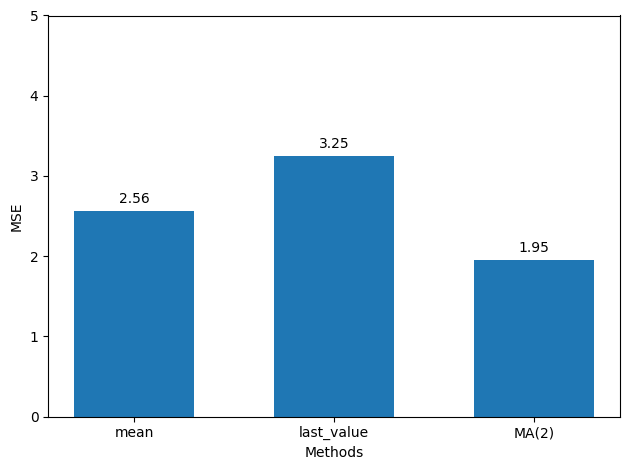

In [22]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.6)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(round(value, 2)), ha='center')

plt.tight_layout()

to obtain our predictions in the original scale of our dataset, we need to use the
first value of the test as our initial value. Then we can perform a cumulative sum to
obtain a series of 50 predictions in the original scale of the dataset. We will assign
these predictions to the `pred_widget_sales column`.

In [24]:
# Initialize an empty column to hold our predictions
df['pred_widget_sales'] = pd.Series()

# Inverse-transform the predictions to bring them back to the original scale of the dataset:
df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()

df.tail()

,widget_sales,pred_widget_sales
495,64.087371,60.335201
496,63.992081,61.218392
497,63.029894,61.365771
498,61.671797,60.895973
499,59.443839,60.832373


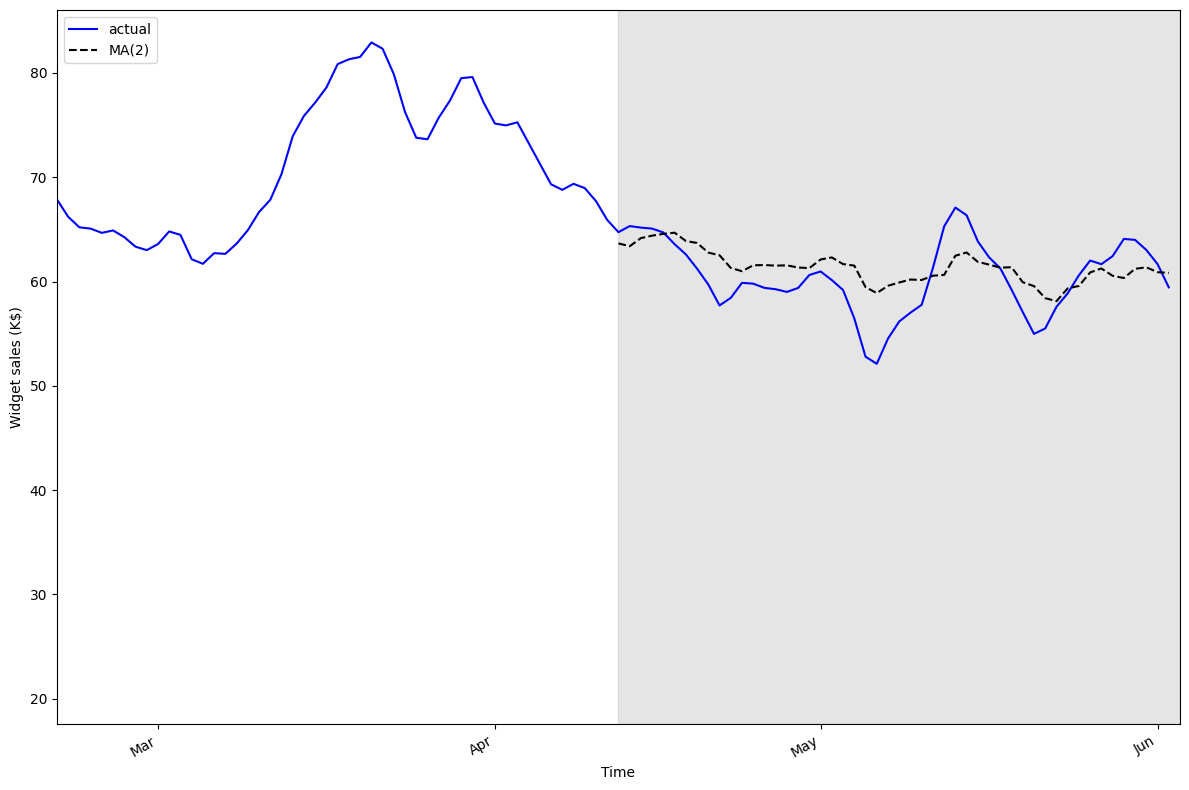

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(df['widget_sales'], 'b-', label='actual')
ax.plot(df['pred_widget_sales'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (K$)')

ax.axvspan(450, 500, color='#808080', alpha=0.2)

ax.set_xlim(400, 500)

plt.xticks(
    [409, 439, 468, 498], 
    ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

Our forecast curve, shown with a dashed line, follows the general trend of the observed values, although it does not predict bigger troughs
and peaks.

In [27]:
from sklearn.metrics import mean_absolute_error

# The average of the absolute difference between the predicted and actual values

mae_MA_undiff = mean_absolute_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])

print("Mean Absolute Error:",mae_MA_undiff.round(2))

Mean Absolute Error: 2.32


This prints out an MAE of 2.32. Therefore, our predictions are, on average, off by
$2,32, either above or below the actual value. Remember that our data has units of
thousands of dollars, so we multiply the MAE by 1,000 to express the average absolute
difference.